# How to fit Deep Compartment Models

Welcome to this tutorial on fitting deep compartment models (DCMs). In this tutorial, we will fit a basic DCM to a public data set of 32 patients who have received a single dose of warfarin. This tutorial covers how to load a NONMEM-compatible data set, definition of a compartment model in the DifferentialEquations package in julia, and how to prepare and fit a DCM to this data. We will cover some of the basics in selecting an appropriate compartment model and neural network structure.

We are assuming here that you already have julia installed, and have added the DeepCompartmentModels package to julia.

* **Step one: Loading the DeepCompartmentModels.jl package into julia.**

In julia, packages can be imported via either an `import` or `using` statement. The `using` statement is convenient in that it loads the relevant functions from the package into the global scope, meaning that we can directly call the functions instead of having to write `DeepCompartmentModels.fit!` etc.

We can instead use `import` to be more explicit with respect to where our functions originate from. This also means that any name clashes between packages can be resolved. For example, many packages in the SciML ecosystem export a function named `predict`. The origin of this function can often be resolved based on the type of the arguments (and it is unlikely that another library would also used `DCM` and `Population` types), but it could be nice to be explicit in such cases and use `DeepCompartmentModels.predict`. This is of course up to your personal preferences.

In [ ]:
using DeepCompartmentModels

Great! The functions in the DeepCompartmentModels.jl package are now loaded in the global scope. It is likely that this took some time. This is because julia first needs to compile functions before they can be used (and we have not performed much optimization yet in this regard). This also means that the first time you call the `fit!` function it might take longer to get results than expected. This is because julia needs to compile the gradient calculation using automatic differentiation. Afterwards, calculating the gradient is very fast.

We can now move on to step two:

* **Step two: Loading your data set into a Population.**

The DeepCompartmentModels package directly supports many NONMEM compatible data sets. That means that when your data set can be loaded into NONMEM without any errors (kudos to you already!), you are likely able to load it into julia!

If you do not have access to NONMEM, just know that we work with data sets that contain a single observation per row. This means that there are multiple rows for a single individual. In each row, either a dosing event (i.e. DOSE, RATE, and DURATION columns) or a concentration (DV column) is provided to the program. The MDV column is used to differentiate between these two options (MDV = 0 means a DV is provided, DV = 1 means a DOSE). Do not provide empty rows (i.e. an empty DOSE or DV). Since the DCM predicts a continuous solution, you can obtain predictions at specific time points via interpolation of the final solution. There is thus no need to add these to the data set. In NONMEM you previously would have had to add these rows in order to obtain predictions at specific time points of interest.

"*What is a Population?*"

We use a Population to store covariate, time, DV, and dosing information into a single object to make analysis more convenient. This means that you can just pass a Population around instead of many different variables.

We've added a convenient `load` function, which accepts a string detailing the location of the data set file (currently we only support .csv), and a vector of Strings or Symbols (somewhat similar to `$column` in R) to select which covariates to use in the analysis.

In [ ]:
file = "./data/warfarin.csv"
covariates = [:WEIGHT, :AGE, :SEX] # Symbols can be recognized by the colon (:) before the column name.

population = load(file, covariates; DVID=1) # We set DVID to 1 since the data set also contains PD data.

* **Step three: Defining our model**

Now that we have our Population loaded in, our next step is to define a compartment model and neural network to make some predictions! Defining our compartment model in julia is simple, and the DeepCompartmentModels.jl package already offers an expanding list of ready-to-go compartment models. In this tutorial we will use a two compartment model with an transition compartment representing the absorption of the drug after an oral dose of warfarin. The structure of this model is as follows:

<img src="./assets/compartment_model.svg" width="375" title="Two compartment model with absorption">

In [ ]:
function two_comp_abs!(dA, A, p, t)
    kₐ, k₂₀, k₂₃, k₃₂, D = p

    dA[1] = D - kₐ * A[1]
    dA[2] = kₐ * A[1] + A[3] * k₃₂ - A[2] * (k₂₀ + k₂₃)
    dA[3] = A[2] * k₂₃ - A[3] * k₃₂
end

# When dealing with infusions, it is better to use the CL, V1, ..., etc. naming convention. This is 
# because it allows one to explicitly reference the relationship in k₁₀ = CL / V1. This is important
# seeing as infusions will be handled as (D / V1). If we would use k₁₀, V1 = p instead of CL, V1 = p 
# the gradient relationship between k₁₀ and V1 is lost.

# In the above case, we are not interested in the volume of the transit compartment, and thus it is 
# implicitly learnt as part of kₐ.

Next up is us defining our neural network structure. This can be daunting as there is an immensive array of options and most pharmacometricians likely do not have much experience with choosing neural network architectures. Luckily, we found that the neural network structure does not have to be complex to obtain accurate results.

Here we will use a very simple encoder structure. The neural network learns to predict the PK parameters (referenced as $\zeta$ in our paper) based on the covariates. This process is similar to that of fixed effects estimation in NONMEM or equivalent software. Since generally simple functions have been used to include covariates in NLME models, using a simple neural network seems to be sufficient.

We will use the following basic architecture:

<img src="./assets/neural_network.svg" width="375" title="Our simple encoder architecture">

This neural network has only one hidden layer, which feeds into the output layer using an activation function (we have used the `swish` activation function). Other good options for the activation function would be a `sigmoid`, `tanh` or `relu` (the `swish` is essentially an fully differentiable `relu` function) activation function. We use 16 neurons for the hidden layer in the below example. Finally, we put a `softplus` activation function on the output layer to ensure that the PK parameters are greater than zero.

In [ ]:
import Flux # An easy to use neural network library in julia.

NN = Flux.Chain(
    Flux.Dense(3, 16, Flux.swish), # hidden layer
    Flux.Dense(16, 4, Flux.softplus) # output layer
)

# Alternatively, we can remove the activation on the final layer and add an additional 
# layer (without parameters) which includes an initial estimate of the PK parameters:
#
# initial_estimate = [0.10, 0.18, ]
#
# NN = Flux.Chain(
#     Flux.Dense(3, 16, Flux.swish), # hidden layer
#     Flux.Dense(16, 4),
#     x -> (Flux.celu.(x, .999) .+ ones(4)) .* initial_estimate
# )

* **Step four: Fitting the neural network to our Population**

We now arrive at our final step, which involves initiating the model and fitting it to our Population. Most of the specifics have been abstracted away, and so fitting the model can be done using only a single line of code. Here we use the ADAM optimizer (which is quite commonly used) to update our neural network parameters using a initial learning rate of $1\mathrm{e}{-3}$. The learning rate affects the size of the update to the neural network weights after each iteration. Setting it too low can quickly push the objective into a local minimum and slows down training, while setting it too high results in the loss jumping around, and the objective never settling into a minimum.

In [ ]:
model = DCM(two_comp_abs!, NN, 3; measurement_compartment=2)

fit!(model, population, Flux.ADAM(1e-3); callback=monitor_loss, iterations=1500)

And we are done! Right away we can predict the concentration for the patients in our population, or we can use the same model to predict for new populations. Fitting the model to these new populations is as simple as calling the `fit!` function and updating the parameters based on the new population. One thing to remember is to use the same normalization scaling for the new population as was used for the population used to train the model.


**Using train and test sets**

In the above example, we have fit a DCM on all our data. It is however advised to leave a small number of patients (usually 20-30% of the samples) out of the train set in order to test the accuracy of our model on unseen samples. Since neural networks can be arbitrarily good at learning to perform predictions, we run the risk of **overfitting**. This is when the neural network is (almost) perfectly adapted to the current data, but performs poorly on unseen samples. We can adress overfitting by monitoring the difference between the training loss and test loss. When these two start to diverge, we identify that our model starts to overfit.

Below, we split our population in a train and test set, and define a new callback in order to monitor the test set loss in addition to the train set loss.

In [ ]:
train_population, test_population = create_split(population; ratio=0.7)

my_callback(loss, epoch) =
    println("Epoch $epoch, training loss: $loss, test loss: $(mse(model, test_population))")

# re-initialize the model
model = DCM(two_comp_abs!, NN, 3; measurement_compartment=2)

fit!(model, train_population, Flux.ADAM(1e-3); callback=my_callback, iterations=200)

**Exploiting the `fit!` callback interface**

We can make these callbacks as complex as we wish. We could for example plot the train and test loss over time, along with a goodness-of-fit plot of the test set samples:

In [13]:
import Plots

train_loss = []
test_loss = []

function my_second_callback(loss, epoch)
    push!(train_loss, loss)
    push!(test_loss, mse(model, test_population))
    plta = Plots.plot(train_loss, xlabel="Epoch", ylabel="Mean squared error", label="Training loss")
    Plots.plot!(test_loss, label="Test loss")
    
    pltb = Plots.scatter(map(pred -> pred.u, predict(model, test_population; tspan=(-.1, 120.))), test_population.y, color="#5db1d1", markerstrokecolor="#5db1d1", xlabel="Predictions", ylabel="Observations", legend=false)
    Plots.plot!([-1., 20.], [-1., 20.], color=:black)
    
    # Clear the current jupyter notebook output, should be removed if you are not using jupyter
    IJulia.clear_output(true)
    display(Plots.plot(plta, pltb, layout=(1, 2), size=(800, 300)))
end


# re-initialize the model
model = DCM(two_comp_abs!, NN, 3; measurement_compartment=2)

fit!(model, train_population, Flux.ADAM(1e-3); callback=my_second_callback, iterations=1000)

**Producing plots**

We can easily produce visualizations for the complete population or single individuals. In this tutorial we use the Plots.jl plotting library in julia. If plotting using this library feels foreign, the Gadfly.jl library is more similar to ggplot2 in R.

Nonetheless, using the Plots.jl library is simple. To create a line, we call `Plots.plot(x, y)`, in order to create a scatter plot we call `Plots.scatter(x, y)`. To update an existing plot, we add an `!` to the end of the function name (`!` in julia indicate that the function acts directly on an existing variable).

The `predict` in DeepCompartmentModels.jl returns a ODESolution, which can be directly used in conjunction with the Plots.jl library. This means we only need to call `Plots.plot(predict(model, individual))` in order to plot for a single patient. Default behaviour of the `predict` function is to predict for the time points at which measurements (i.e. the DV) were provided. We can instead obtain a continuous solution by setting `interpolating = true`. If we also want to inspect the drug concentration in the other compartments we can set `full = true`. Finally, we can inspect only a certain time window by setting `tspan = (start_time, end_time)`. Be careful here that setting the `start_time` after initial dosing events results in these events never being activated. We thus do not advise changing the `start_time`, so keep it at -0.1 (in order to not miss any dose at $t = 0$).   

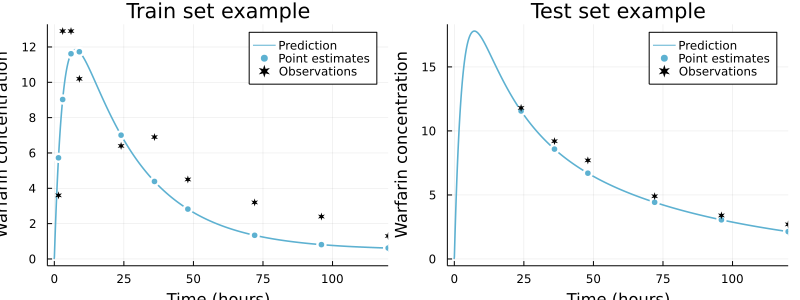

In [14]:
# Plotting the results for a single patient in the train and test set.
plt_train = Plots.plot(predict(model, train_population[1]; interpolating=true, tspan=(-0.1, 120)), color="#5db1d1", linewidth=1.6, label="Prediction")
Plots.scatter!(plt_train, predict(model, train_population[1]; tspan=(-0.1, 120)), color="#5db1d1", markerstrokecolor=:white, markersize=5, markerstrokewidth=4, xlabel="Time (hours)", ylabel="Warfarin concentration", label="Point estimates")
Plots.scatter!(train_population[1].t, train_population[1].y, color=:black, markershape=:star6, xlim=(-2.5, 120.), title="Train set example", label="Observations")

plt_test = Plots.plot(predict(model, test_population[1]; interpolating=true, tspan=(-0.1, 120)), color="#5db1d1", linewidth=1.6, label="Prediction")
Plots.scatter!(plt_test, predict(model, test_population[1]; tspan=(-0.1, 120)), color="#5db1d1", markerstrokecolor=:white, markersize=5, markerstrokewidth=4, xlabel="Time (hours)", ylabel="Warfarin concentration", label="Point estimates")
Plots.scatter!(test_population[1].t, test_population[1].y, color=:black, markershape=:star6, xlim=(-2.5, 120.), title="Test set example", label="Observations")

Plots.plot(plt_train, plt_test, layout=(1,2), size=(800, 300))

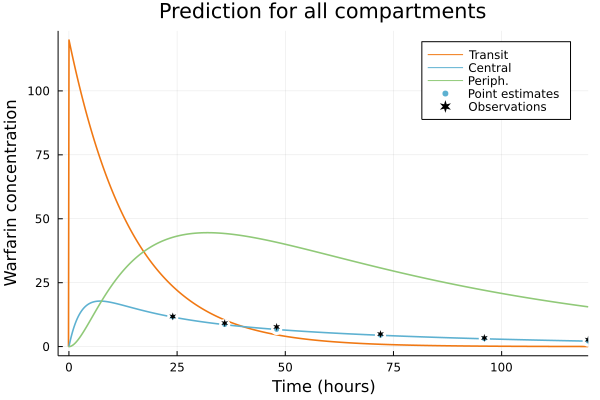

In [15]:
# Plotting the concentrations in all compartments
plt = Plots.plot(predict(model, test_population[1]; interpolating=true, tspan=(-0.1, 120), full=true), linewidth=1.6, color=["#f07813" "#5db1d1" "#90c978"], label=["Transit" "Central" "Periph."])
Plots.scatter!(plt, predict(model, test_population[1]; tspan=(-0.1, 120)), color="#5db1d1", markerstrokecolor=:white, markersize=5, markerstrokewidth=4, xlabel="Time (hours)", ylabel="Warfarin concentration", label="Point estimates")
Plots.scatter!(plt, test_population[1].t, test_population[1].y, color=:black, markershape=:star6, title="Prediction for all compartments", xlim=(-2.5, 120.), label="Observations")


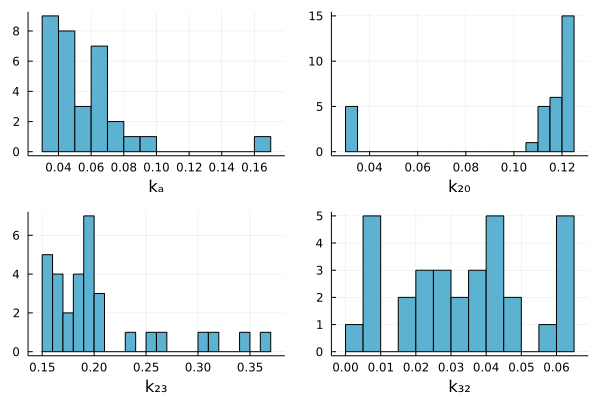

In [16]:
# We can check the PK parameter predictions for all patients by simply 
# calling the model using the population:

ζ = model(population.x)

# We can for example plot a histogram to investigate the distribution of the PK parameters:
Plots.histogram(ζ', bins=20, xlabel=["kₐ" "k₂₀" "k₂₃" "k₃₂"], color="#5db1d1", layout=4, label=nothing)

# If we would want, we could further explore the PK parameter distributions, for example by 
# investigating the covariate responsible for the two apparent groups in PK parameters 
# (which is likely arising as a result of differences in SEX).

That's it for this tutorial! Thank you for your interest in using Deep Compartment Models. If you have any remaining questions or run into any problems, please raise an issue on the DCM.jl github repository. Help us improve the library so detailing issues you face when for example loading your data set, or how you would like to use a DCM for your specific use case.